<a href="https://colab.research.google.com/github/pavanKulkarni2000/form_processing/blob/master/from.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytesseract==0.3.4
!sudo apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=e1cd610b0c6f5680afa18daa482cbe2ae1d562360b485a942d35c5db5fc0735f
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

In [0]:
import json

class field:
  def __init__(self, txt=None,txtrect=(-1,-1,-1,-1),ftype=None):
    self.txt=txt
    self.txtrect=txtrect
    self.ftype=ftype
    self.struct={"ftype":None,"ftxt":txt,"txtrect":tuple(txtrect),"fradius":0,"fcenter":tuple((-1,-1)),"fboundingBox":tuple((-1,-1,-1,-1))}

  def printJson(self):
    print(json.dumps(self.struct,indent = 4))

class radio:
  def __init__(self, pos=(-1,-1,-1)):
    self.pos=pos
    self.fname="radio"

class date:
  def __init__(self, bbox=(-1,-1,-1,-1)):
    self.bbox=bbox
    self.fname="date"

class textField:
  def __init__(self, bbox=(-1,-1,-1,-1)):
    self.bbox=bbox
    self.fname="textField"

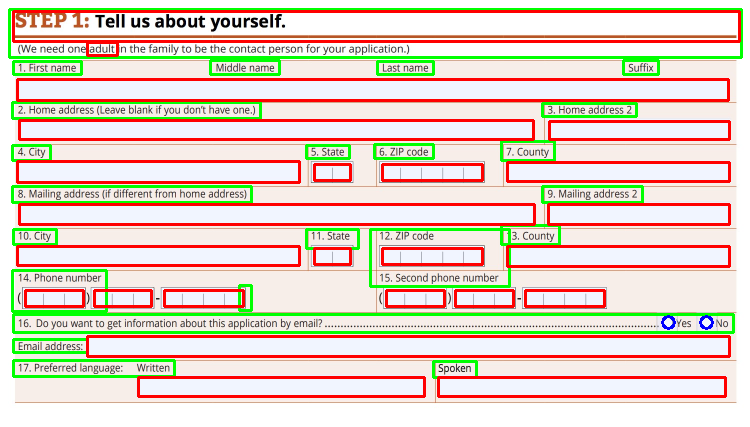

In [0]:
import numpy as np
import cv2
import pytesseract
from PIL import Image
from google.colab.patches import cv2_imshow

large = cv2.imread('/content/drive/My Drive/FormProcessing/sample_forms/test.jpeg')
h = large.shape[0]
w = large.shape[1]
h = h*1/2
w = w*1/2
rgb = cv2.resize(large, (int(w), int(h)) )
#rgb = cv2.pyrDown(large)
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel = np.ones((6,12), np.uint8)
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#k = 4 or 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,3))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

# using RETR_EXTERNAL instead of RETR_CCOMP
contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros(bw.shape, dtype=np.uint8)
count=0
fields=[]
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    if r > 0.45 and w > 8 and h > 8:
        cv2.rectangle(rgb, (x-1, y-1), (x+w-1, y+h-1), (0, 255, 0), 2)
        new_img = rgb[y:y+h, x:x+w]
        cv2.medianBlur(new_img,9)
        cv2.threshold(new_img, 0, 255, cv2.THRESH_BINARY )
        kernel = np.ones((1,9),np.uint8) 
        cv2.morphologyEx(new_img, cv2.MORPH_OPEN, kernel)
        cv2.Canny(new_img, 100, 200)
        new_img = cv2.resize(new_img, None, fx=5.5, fy=4.5, interpolation=cv2.INTER_CUBIC)
        text = pytesseract.image_to_string(new_img)
        if text!="" and text!=" ":
            fields.append(field(text,(x,y,w,h)))
            # count+=1;
            # print('field '+str(count)+') '+text)
            # print("\n")

ret,thresh = cv2.threshold(small, 200, 255,cv2.THRESH_BINARY)

c = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT,1, 15, param1=50, param2=14, minRadius=5,maxRadius=10)
c = np.uint16(np.around(c))

res1=rgb.copy()
for i in c[0,:]:
    # draw the outer circle
    cv2.circle(res1,(i[0],i[1]),i[2],(255,0,0),2)

#cv2_imshow(res1)


blurred = cv2.GaussianBlur(small, (5,5), 0)
ret,thresh1 = cv2.threshold(blurred,244,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(
    thresh1, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)


rects = []

res2=res1.copy()

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w*h>50 and w>5 and h>5 and w*h<thresh1.shape[0]*thresh1.shape[1]*0.5:
      
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.005 * peri,False)
      # check if the approximated contour has four points
      # if so, it can be labelled as a rectangle
      if len(approx) <25:
        rects.append([x,y,w,h])
        cv2.rectangle(res2,(x,y),(x+w,y+h), (0,0,255), 2)



cv2_imshow(res2)



In [0]:
print(cv2.imread("/content/drive/My Drive/FormProcessing/sample_forms/WhatsApp.png").shape)
cv2.imread("/content/drive/My Drive/FormProcessing/sample_forms/test.png").shape

(728, 1280, 3)


(854, 1500, 3)

In [0]:
fields.sort(key=lambda x: (x.txtrect[1],x.txtrect[0]))
for f in fields:
  f.printJson()
  print()

In [0]:
fields.sort(key=lambda x:( x.txtrect[1] , x.txtrect[0]))
rects.sort(key=lambda x: (x[1] , x[0]))

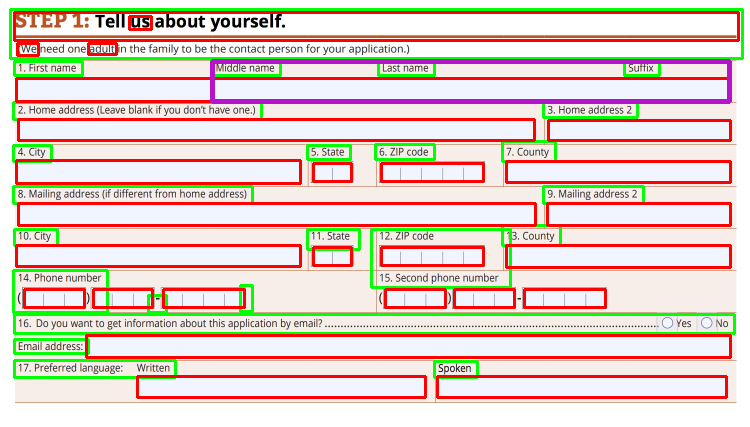

2


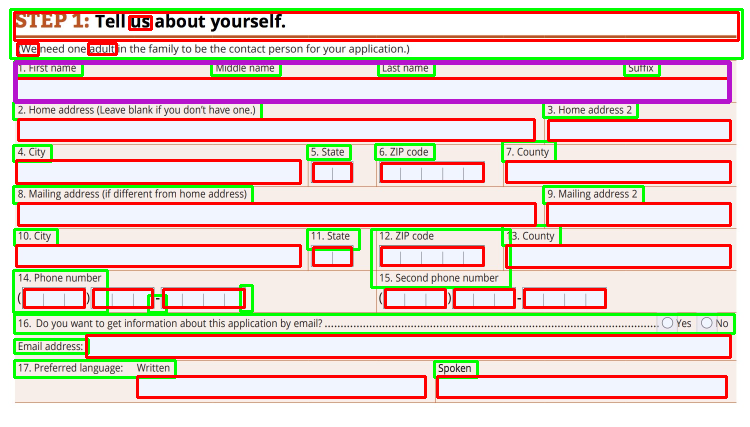

2


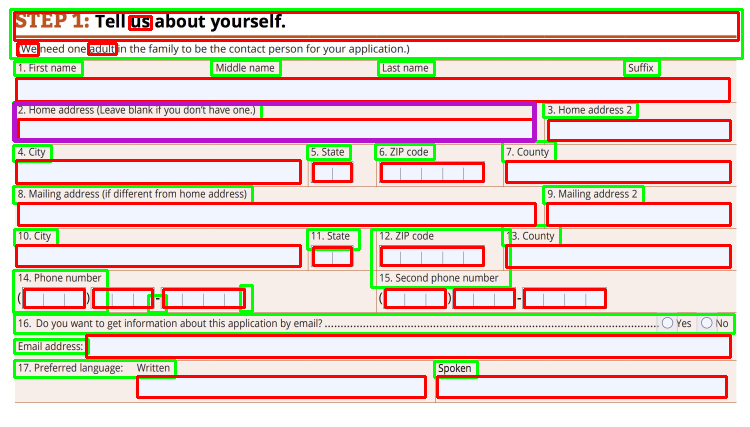

1


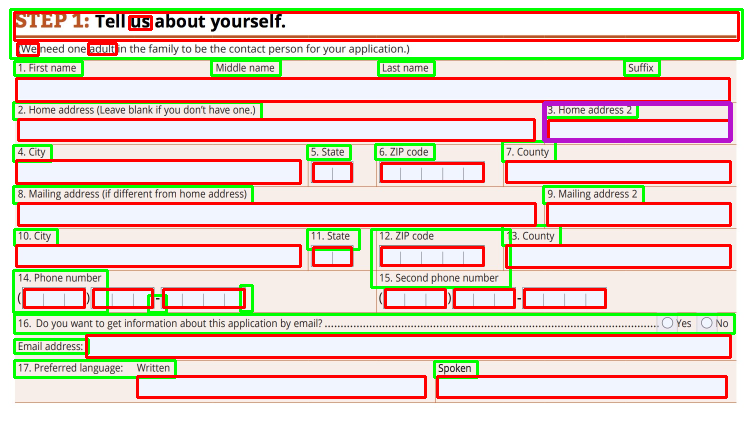

2


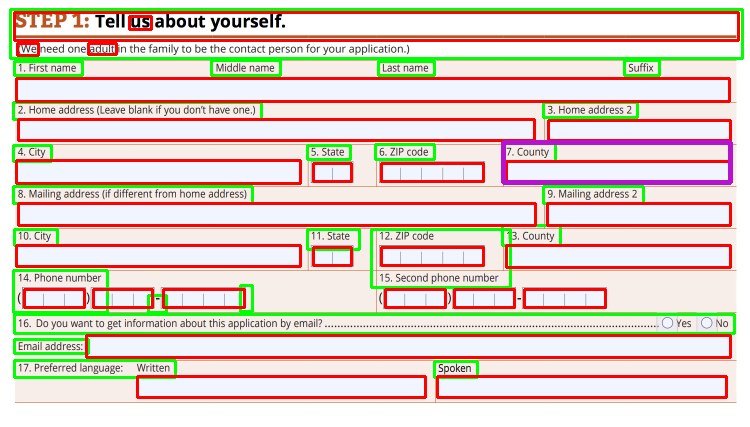

1


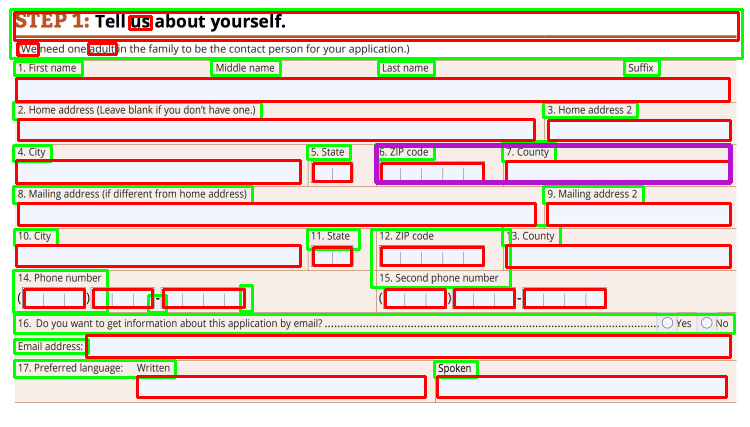

1


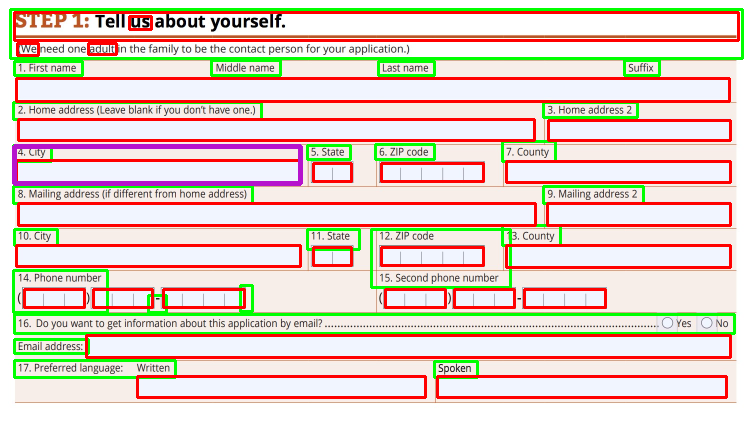

2


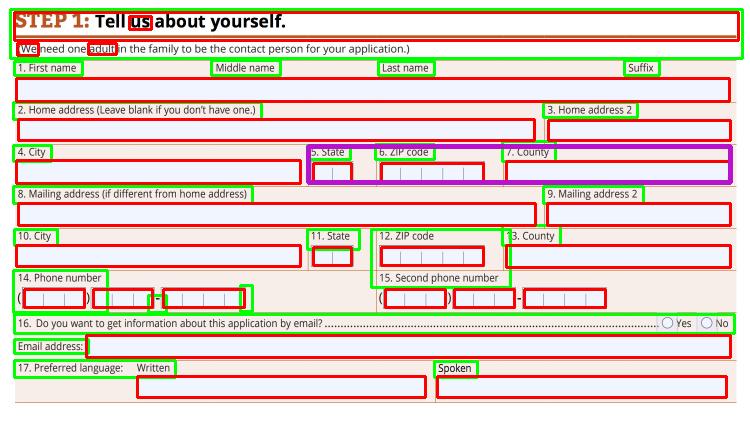

1


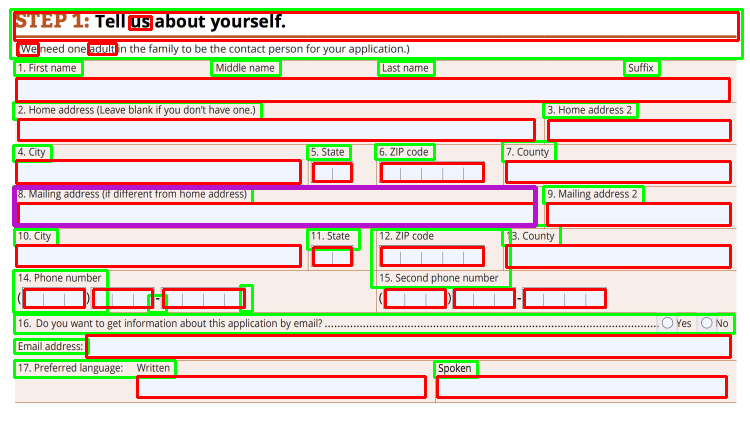

1


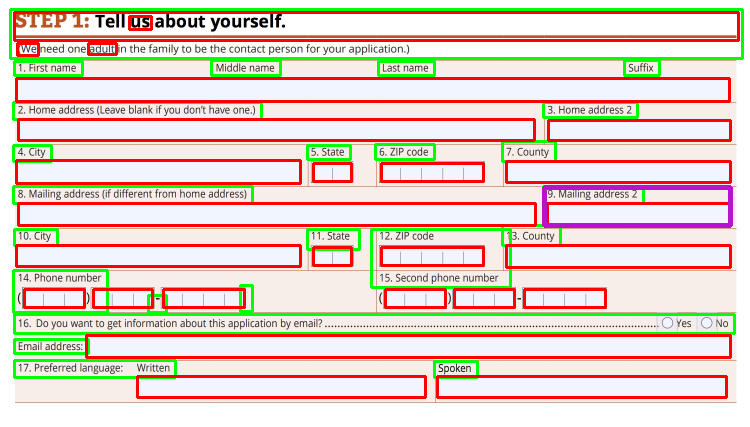

1


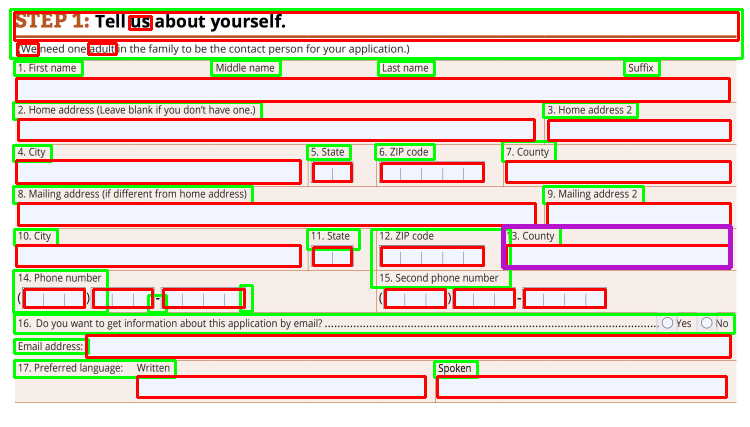

1


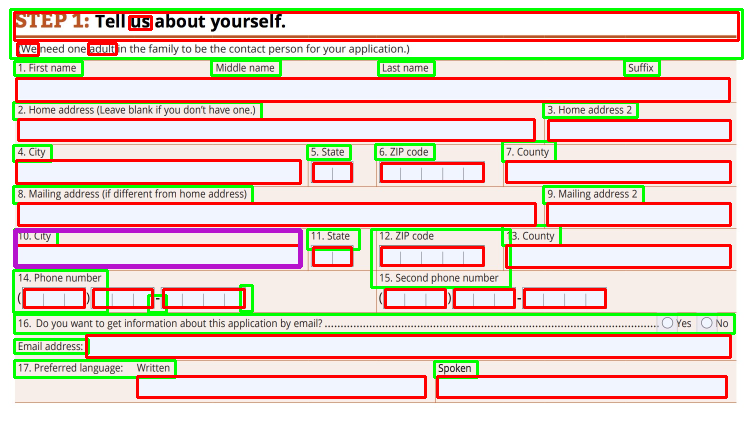

1


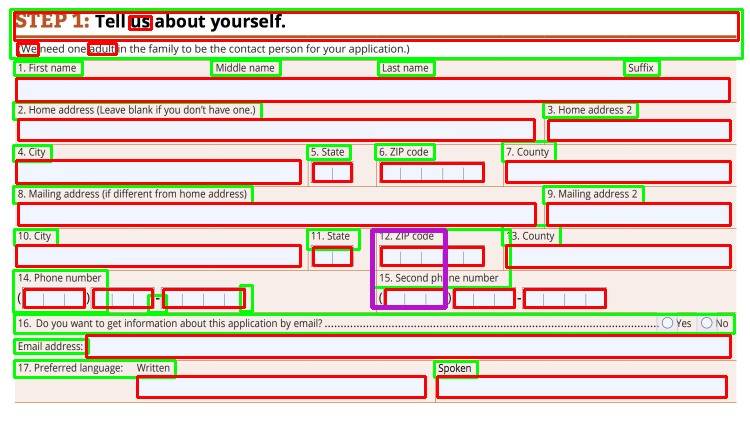

1


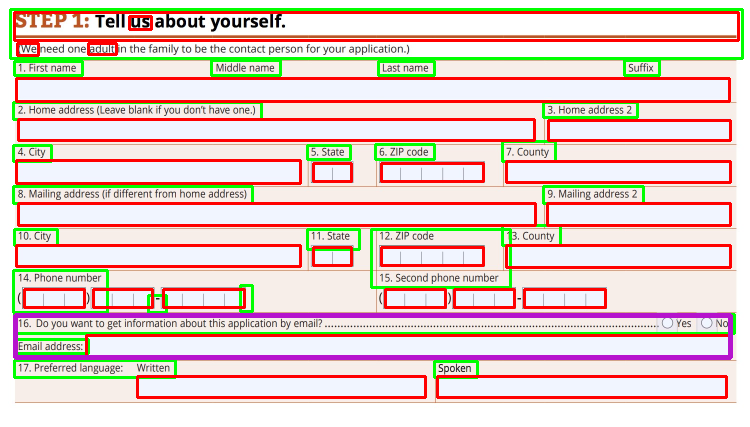

1


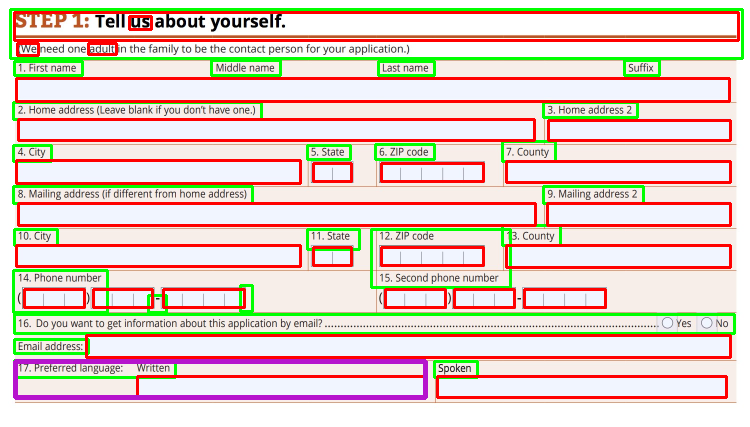

2


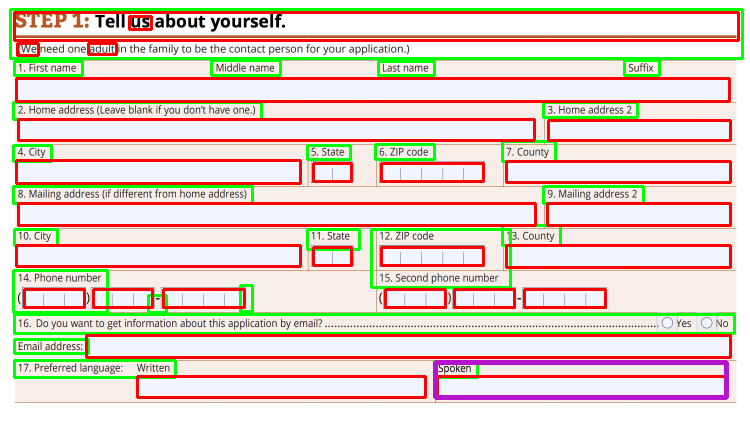

2


In [0]:
#res3=res2.copy()

f=fields.copy()

for a in f:
  (x1,y1,w1,h1)=a.txtrect
  for b in rects:
    (x2,y2,w2,h2)=b
    ar=(x2+w2-x1)*(y2+h2-y1)
    if abs(y2-(y1+h1)) <5 and ar > w2*h2:
      cv2_imshow(cv2.rectangle(res2.copy(),(x1,y1),(x2+w2,y2+h2), (205,19,182), 3))
      a.ftype=textField((x1,y1,x2+w2,y2+h2))
      a.struct["fboundingBox"]=a.ftype.bbox
      print(abs(y2-(y1+h1)))
      break
#cv2_imshow(res3)

In [0]:
for x in f:
  x.printJson()

{
    "ftype": null,
    "ftxt": "STEP 1: Tell us about yourself.\n\n \n\n(We need one adult in the family to be the contact person for your application.)",
    "txtrect": [
        11,
        10,
        732,
        49
    ],
    "fradius": 0,
    "fcenter": [
        -1,
        -1
    ],
    "fboundingBox": [
        -1,
        -1,
        -1,
        -1
    ]
}
{
    "ftype": null,
    "ftxt": "Middle name",
    "txtrect": [
        212,
        61,
        69,
        15
    ],
    "fradius": 0,
    "fcenter": [
        -1,
        -1
    ],
    "fboundingBox": [
        212,
        61,
        729,
        101
    ]
}
{
    "ftype": null,
    "ftxt": "Suffix",
    "txtrect": [
        625,
        61,
        35,
        15
    ],
    "fradius": 0,
    "fcenter": [
        -1,
        -1
    ],
    "fboundingBox": [
        -1,
        -1,
        -1,
        -1
    ]
}
{
    "ftype": null,
    "ftxt": "1. First name",
    "txtrect": [
        15,
        62,
        68,
    

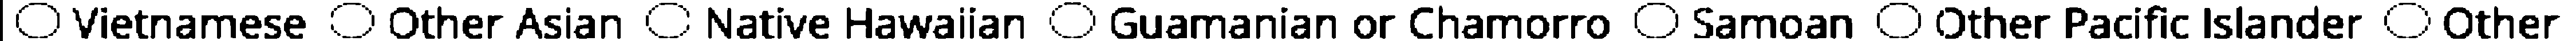

field 1) Cc Vietnamese <2 Other Asian <2 Native Hawaiian “<2: Guamanian or Chamorro ©> Samoan ©) Other Pacific Islander <2 Other




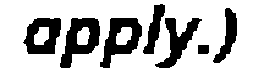

field 2) apply.)




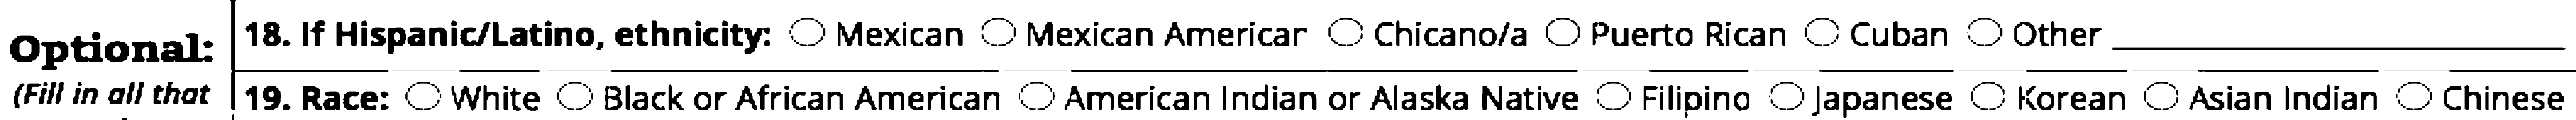

field 3) Optional: " If Hispanic/Latino, ethnicity: “> Mexican “> Mexican Americar ©? Chicano/a © Puerto Rican ©? Cuban “> Other
(Fill in all that |19, Race: —> White “ Black or African American <> American Indian or Alaska Native “ Filipino “~ Japanese ©? Korean ©? Asian Indian “ Chinese




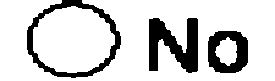

field 4) C)No




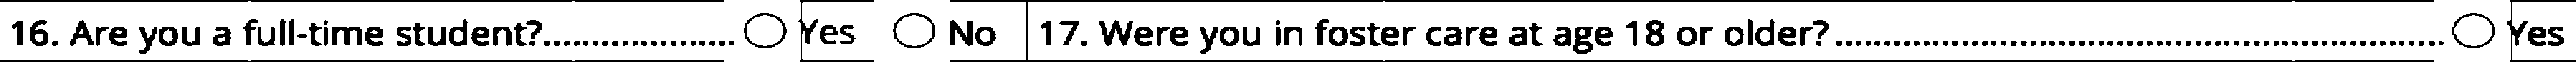

field 5) 16. Are you a full-time student?................. ©) Wes ©) No | 17. Were you in foster care at age 18 OF Oder? vo... cscscsececssescssssescsseescsseessssessssssesensnee CD Yes




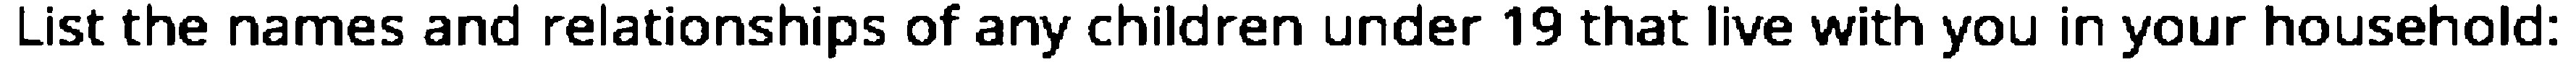

field 6) List the names and relationships of any children under 19 that live with you in your household:




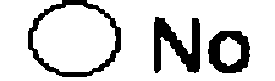

field 7) C)No




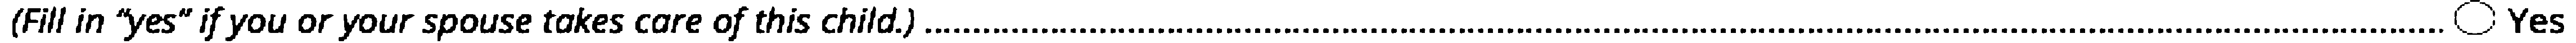

field 8) (Fill in “yes” if you or your spouse takes Care Of thiS CHINA.) ........cccsccccsscsccesececesscnsessssceecseseseseeceuscecteeceascosuscenesansesaseaestessecnessecatessceuececessenesaseesseesestaneecseeseesteteeesesenes &) VOS




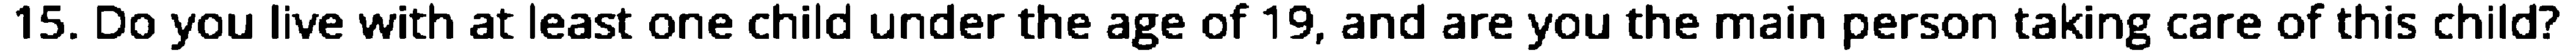

field 9) 15. Do you live with at least one child under the age of 19, and are you the main person taking care of this child?




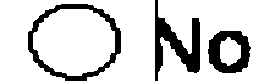

field 10) C)No




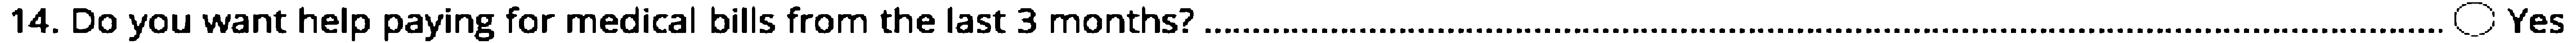

field 11) 14. Do you want help paying for medical bills from the last 3 MONMtHS? ............:cceecssseeesceceesecesecsccessessereecestcneeacestersecsuecneeasseateneecenscoesessestersecssetetenseesseeeeesss ©) Y@S




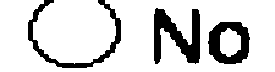

field 12) ( J) No




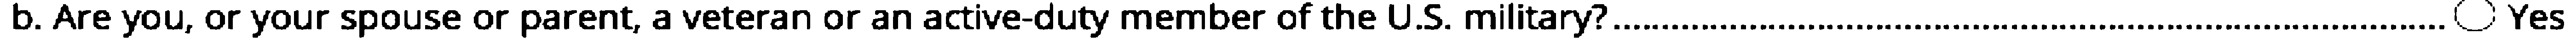

field 13) b. Are you, or your spouse or parent, a veteran or an active-duty member of the U.S. military? «0.0.0... eee eccceeceeececeeeceeneesecnssstanessecesecsseeescorseerseees 7? VOS




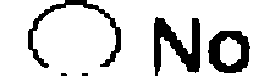

field 14) CINO




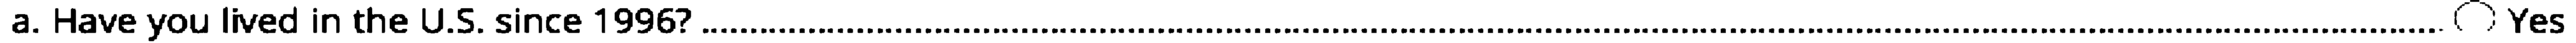

field 15) a. Have you lived in the U.S. SINCE 1996? oo... eee cescssscesecesssseeescseesscssececestesesesseceessestsesescensscstesscesecesuscenesassesasseestesecneseccatessceseescessesesasseseesestareecsteseesteneesreneee © Y@S




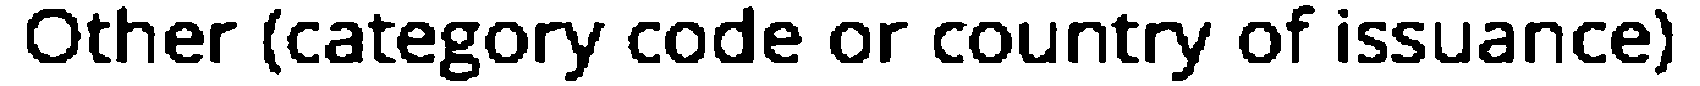

field 16) Other (category code or country of issuance)




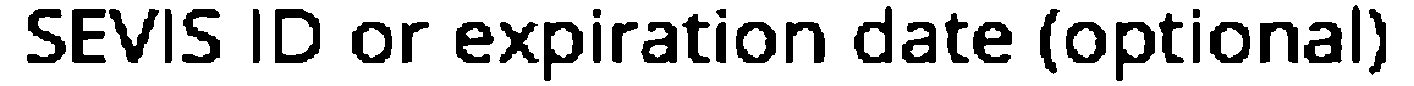

field 17) SEVIS ID or expiration date (optional)




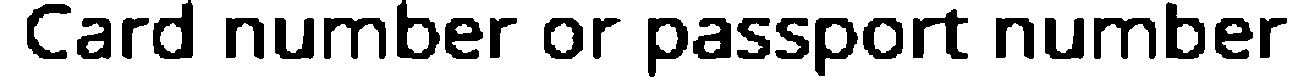

field 18) Card number or passport number




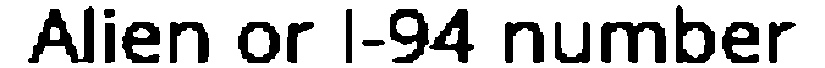

field 19) Alien or |-94 number




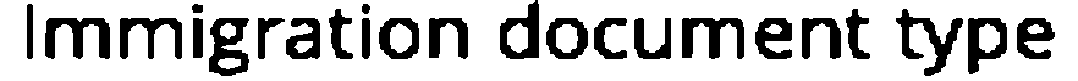

field 20) Immigration document type




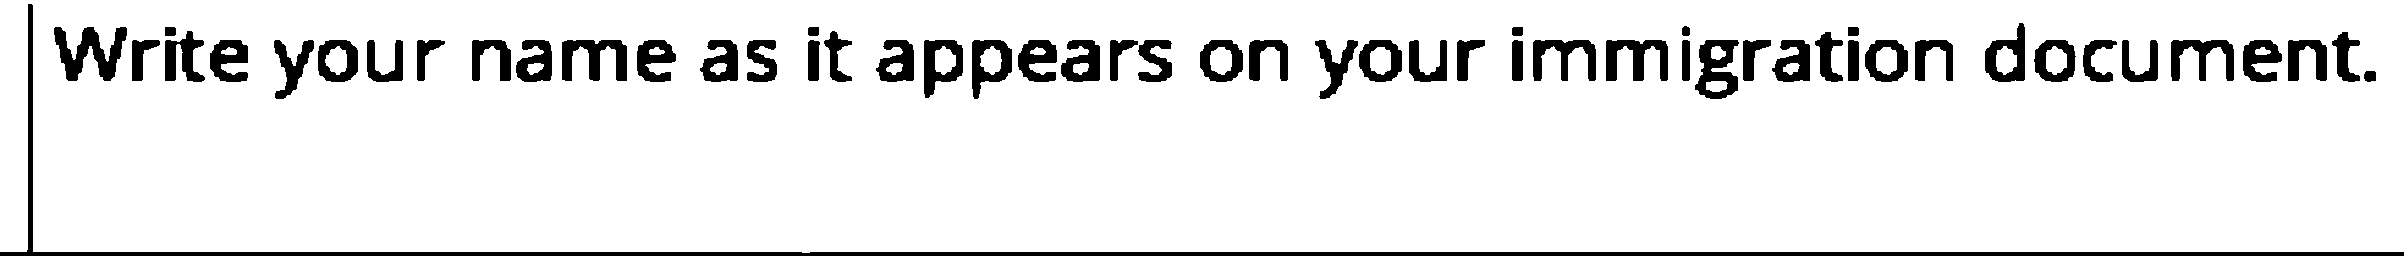

field 21) “ns your name as it appears on your immigration document.




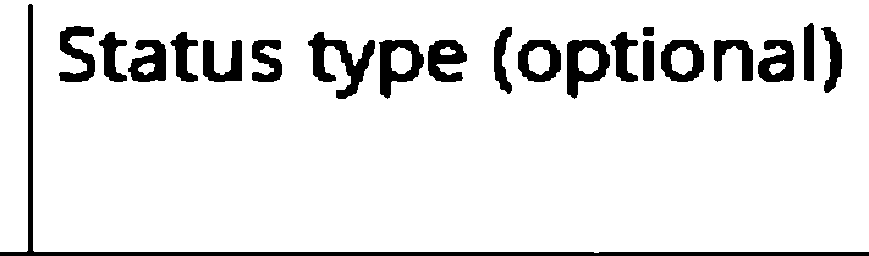

field 22) Status type (optional)




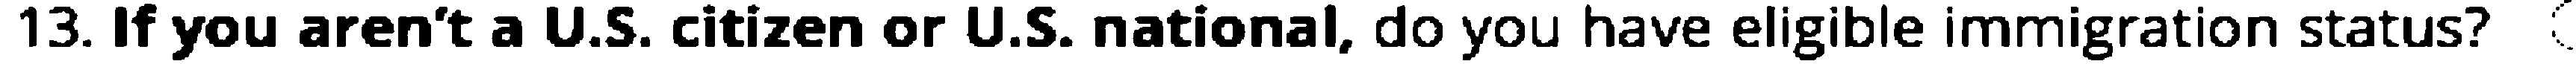

field 23) 13. If you aren't a U.S. citizen or U.S. national, do you have eligible immigration status? ~




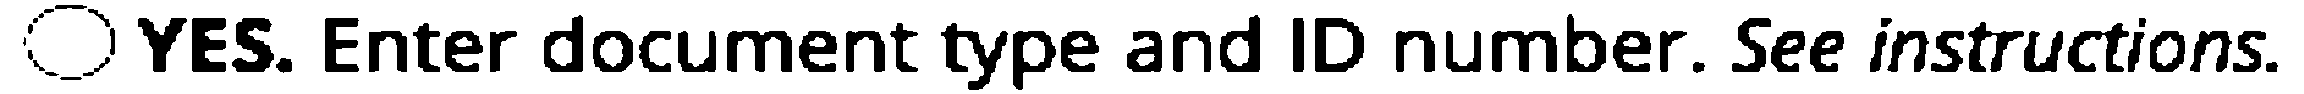

field 24) <.) YES. Enter document type and ID number. See instructions.




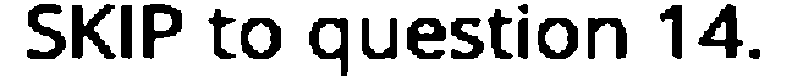

field 25) SKIP to question 14.




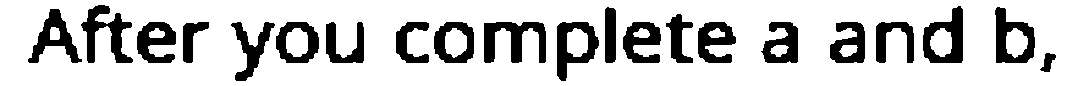

field 26) After you complete a and b,




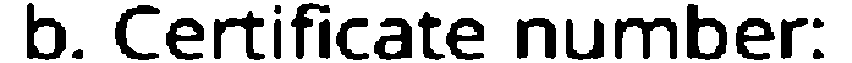

field 27) b. Certificate number:




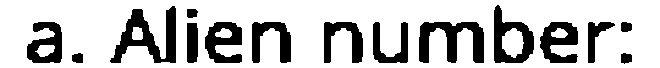

field 28) a. Alien number:




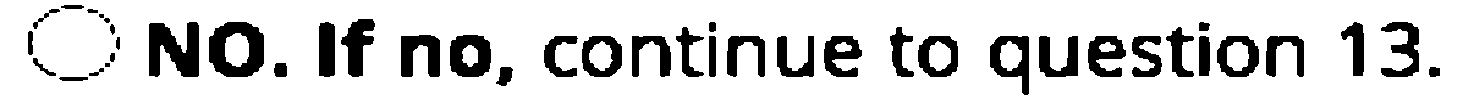

field 29) (NO. If no, continue to question 13.




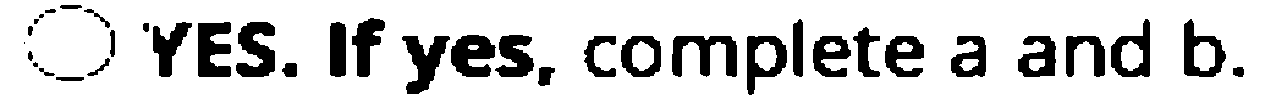

field 30) __) YES. If yes, complete a and b.




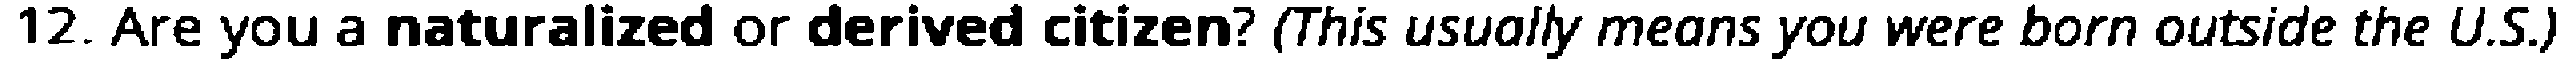

field 31) 12. Are you a naturalized or derived citizen? (This usuaily means you were born outside the U.S.)




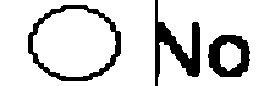

field 32) C)No




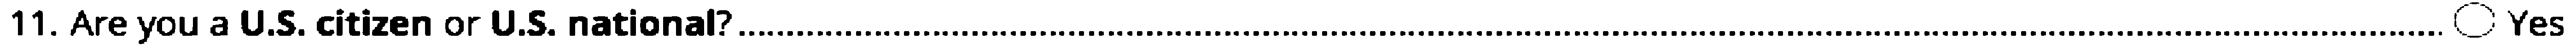

field 33) 11. Are you a U.S. citizen or U.S. Matiomall? oo... cece ces cccsceecscessscscescssessssssesseseussesseusesesscesseusesesecesessesesecsssessceusesssneseessessssussessenstsestensnstesensnseeene © YRS




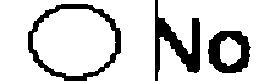

field 34) CYNo




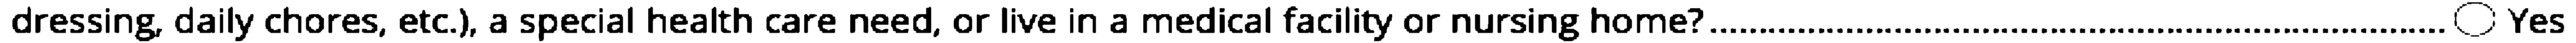

field 35) dressing, daily chores, etc.), a special health care need, or live in a medical facility Or NUPSING NOME? ................:ccccceesceeeeecesseneeessescersecssteesessestereeessteneee G_) YOS




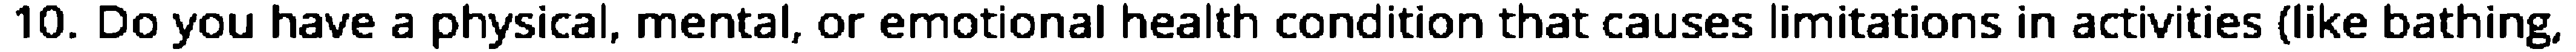

field 36) 10. Do you have a physical, mental, or emotional health condition that causes limitations in activities (like bathing,




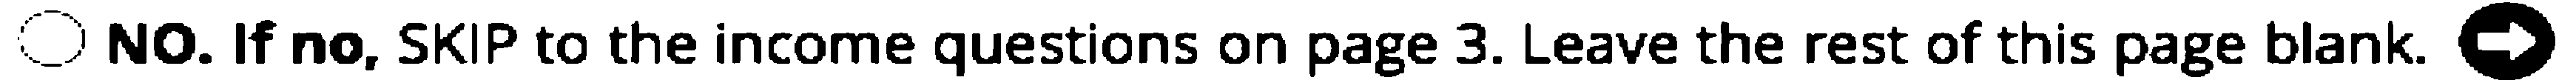

field 37) “_) NO. If no, SKIP to the income questions on page 3. Leave the rest of this page blank. ©




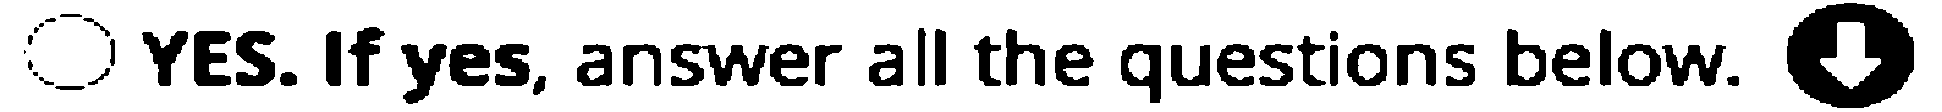

field 38) “_ YES. If yes, answer all the questions below. ©




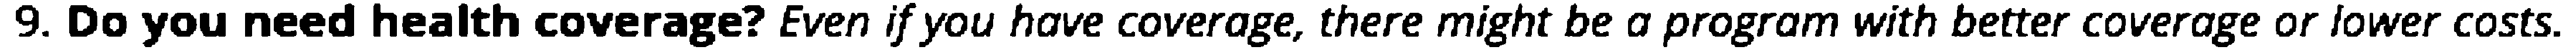

field 39) 9. Do you need health coverage? Even if you have coverage, there might be a program with better coverage or fower costs.




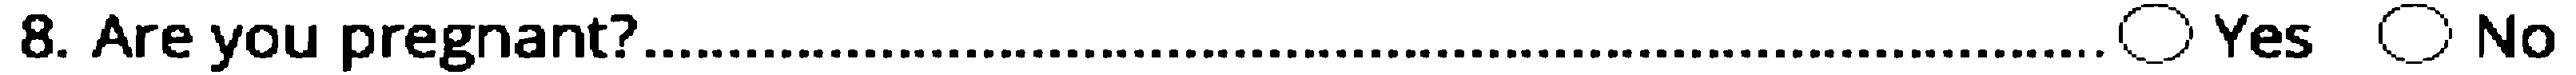

field 40) B. APE YOU POZA? .........cccccccecscesceneecsseceeeessesteneecsceseessssestersessteetessseetereeens ©) YAS © NO




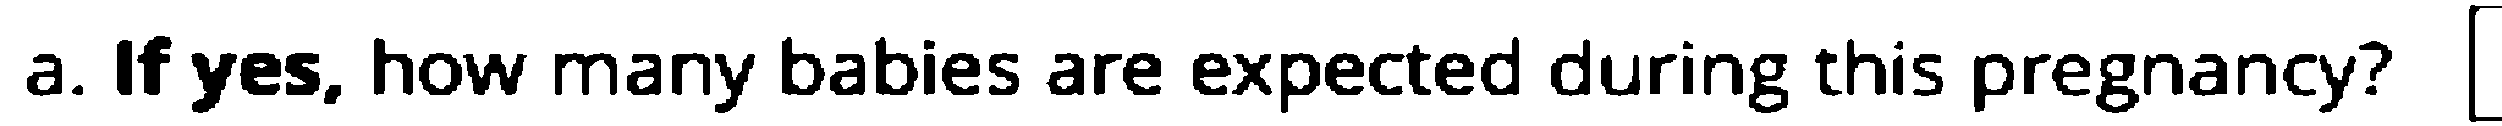

field 41) a. If yes, how many babies are expected during this pregnancy? |




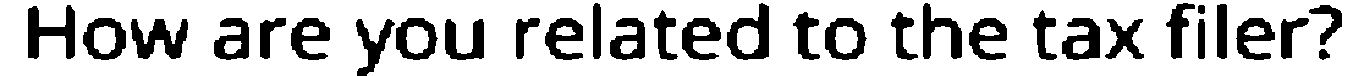

field 42) How are you related to the tax filer?




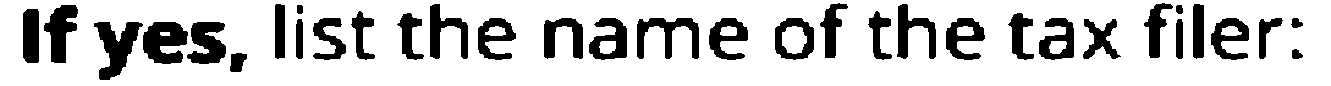

field 43) If yes, list the name of the tax filer:




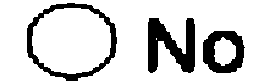

field 44) C)No




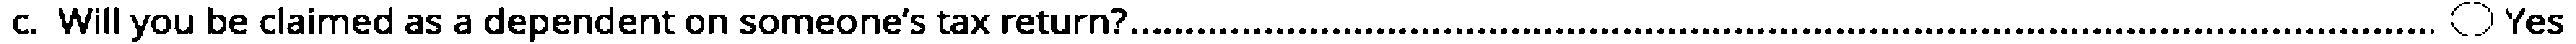

field 45) Cc. Will you be claimed as a dependent on someone's tax FOLULINV? ..cccccccccccccccccnncccccncccccesannccassnessccedannccedsnccnscnsansecesanecnsunascnsccdcnscnscecacecensanecesenaces cy Yes




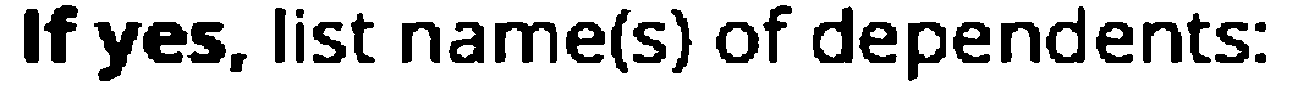

field 46) If yes, list name(s) of dependents:




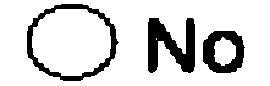

field 47) C)No




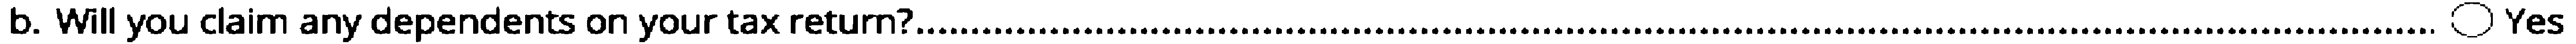

field 48) b. Will you claim any Gependents OM YOUF taX FELUITN?........cccccessccsreccesceeceeersensserscesceuensensceeseesceuanssessenscesceecusesscensecscesaueessenscescrscususscesessseeerseecsers ©) YOS




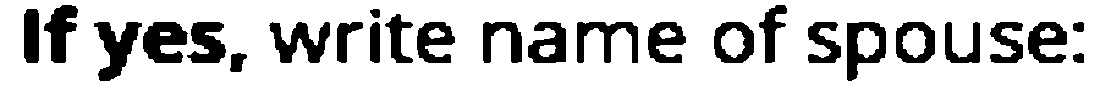

field 49) If yes, write name of spouse:




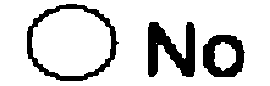

field 50) C)No




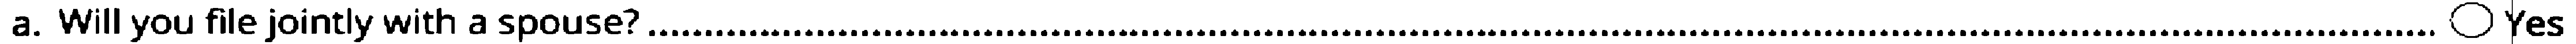

field 51) a. Will you file jointly With 2 SPOUSE? .........ccccccccccccccccccccccescscssesssessesssececcceccesccesanscsscssnessersessesaacecesseeccecanscusussscssesseceseeceeeessesccesanscassssscssesssssersees K—) YOS




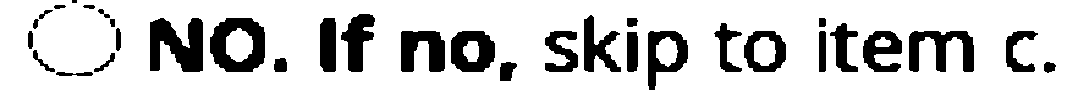

field 52) (NO. tf no, skip to item c.




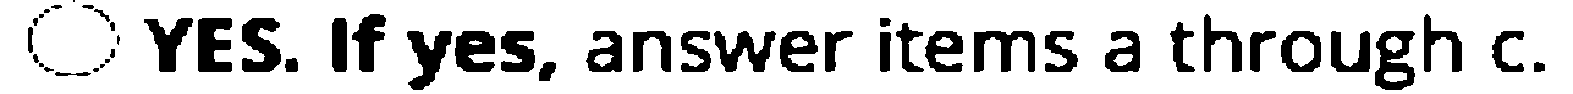

field 53) (> YES. If yes, answer items a through c.




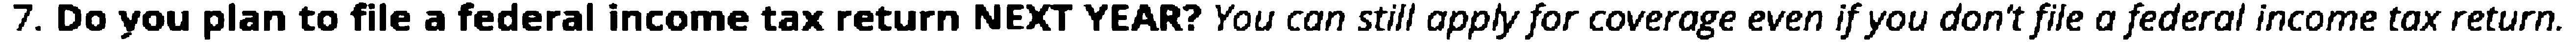

field 54) 7. Do you plan to file a federal income tax return NEXT YEAR? You can stil! apply for coverage even if you don't file a federal income tax return.




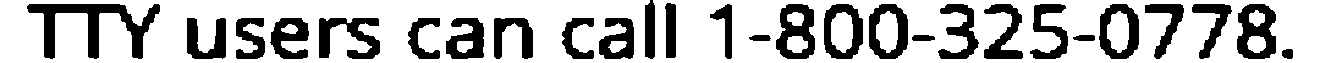

field 55) Try users can call 1-800-325-0778.




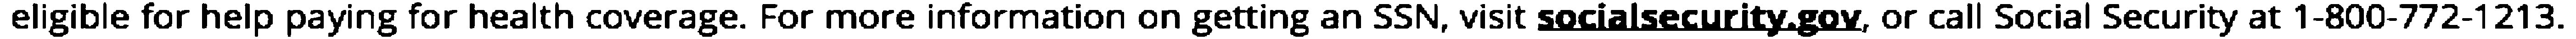

field 56) eligible for help paying for health coverage. For more information on getting an SSN, visit socialsecurity.goy, or call Social Security at 1-800-772-1213.




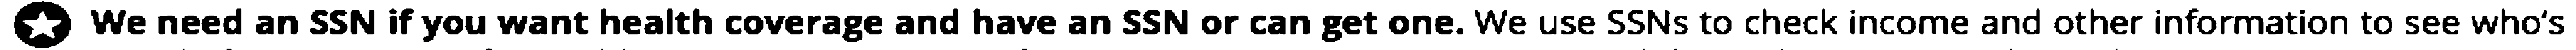

field 57) oS We need an SSN if you want health coverage and have an SSN or can get one. We use SSNs to check income and other information to see who's




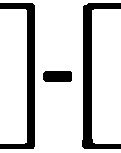

field 58) Ff




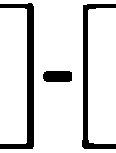

field 59) Ft




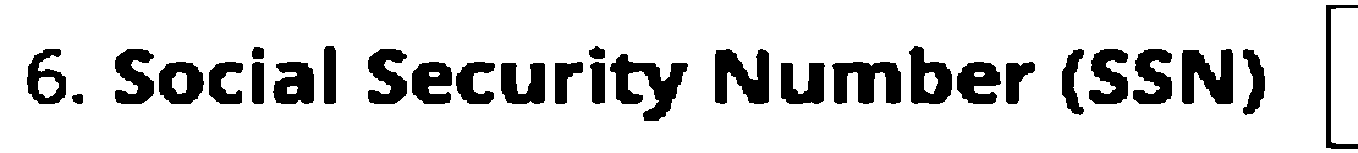

field 60) 6. Social Security Number (SSN) |




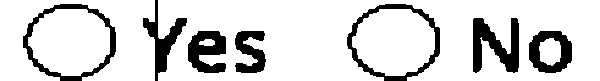

field 61) C)¥es © INo




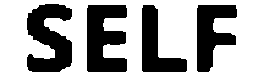

field 62) SELF




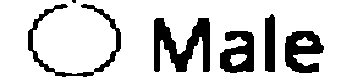

field 63) C) Male




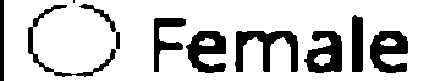

field 64) 'C > Female




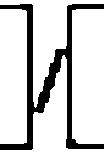

field 65) YW




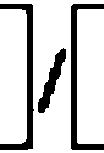

field 66) YW




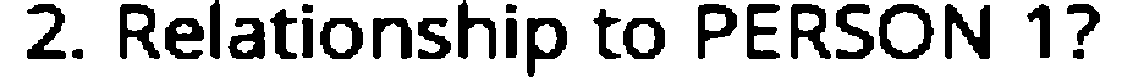

field 67) 2. Relationship to PERSON 1?




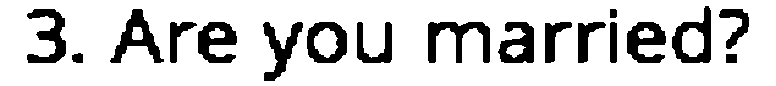

field 68) 3. Are you married?




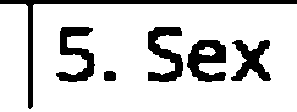

field 69) |S. Sex




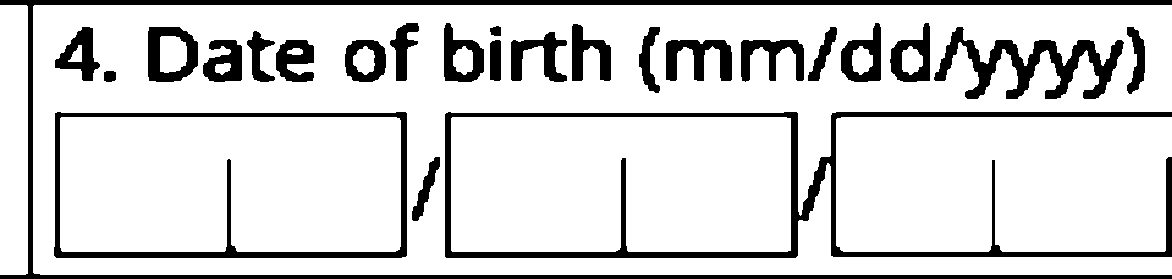

field 70) 4. Date of birth (mm/dd/yyyy)
ae




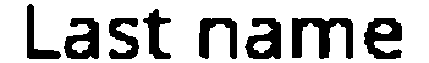

field 71) Last name




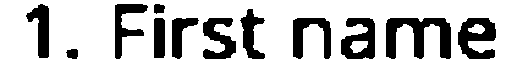

field 72) 1. First name




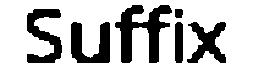

field 73) Suffix




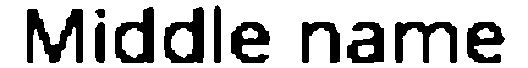

field 74) Middle name




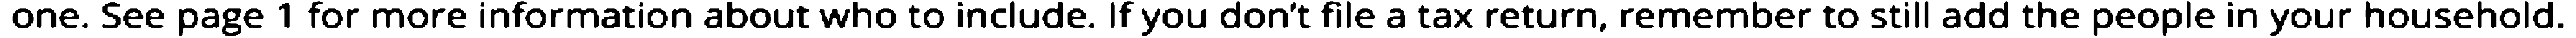

field 75) one. See page 1 for more information about who to include. If you don't file a tax return, remember to still add the people in your household.




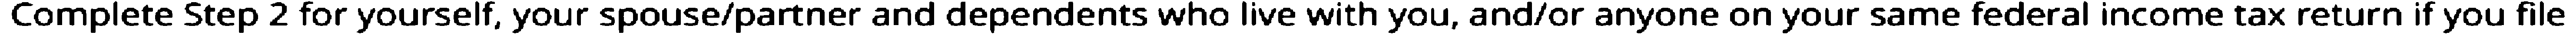

field 76) Complete Step 2 for yourself, your spouse/partner and dependents who live with you, and/or anyone on your same federal income tax return if you file




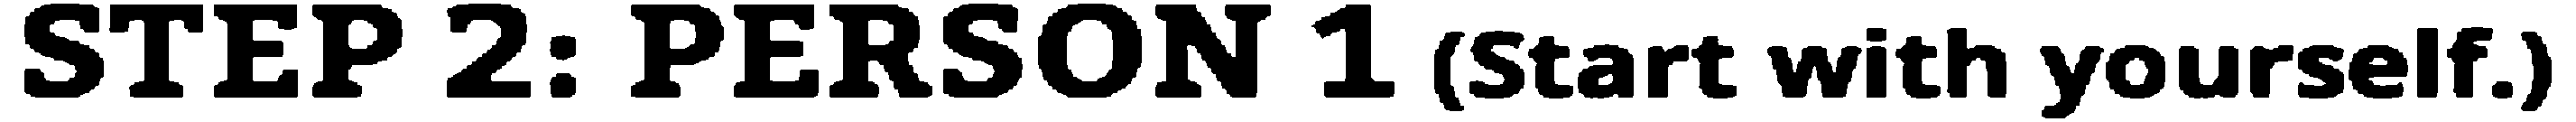

field 77) STEP 2: PERSON 1 (Start with yourself.)




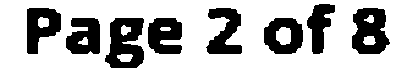

field 78) Page 2 of 8


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



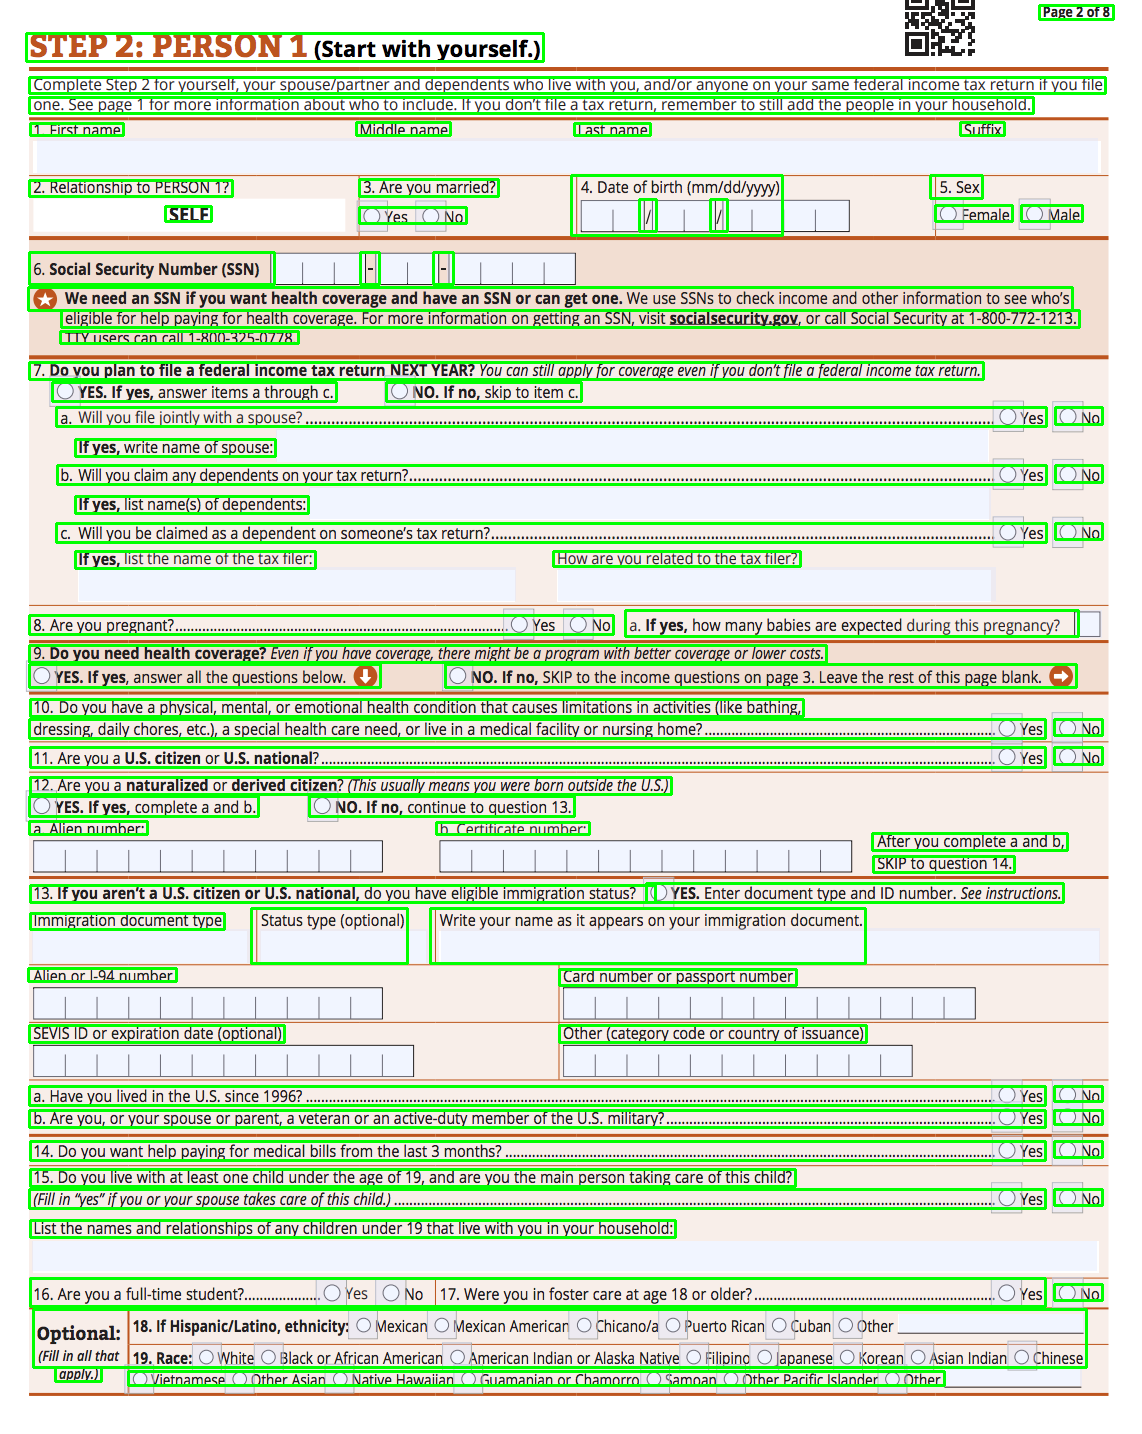

In [67]:
import numpy as np
import cv2
import pytesseract
from PIL import Image
from google.colab.patches import cv2_imshow
import regex as re

rgb = cv2.imread('/content/drive/My Drive/FormProcessing/sample_forms/test1.png')
h = rgb.shape[0]
w = rgb.shape[1]
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

kernel = np.ones((1,9), np.uint8)
grad = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)


contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# co=connected.copy()
# img=rgb.copy()
# img[:,:,0] = co
# img[:,:,1] = co
# img[:,:,2] = co
# for i in contours:
#   t=cv2.boundingRect(i)
#   cv2.rectangle(img, t, (0, 255, 0), 2)
#   print(t)
# cv2_imshow(img)


mask = np.zeros(bw.shape, dtype=np.uint8)
count=0
d = {}
text = ""
labels = []
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    
    if r > 0.45 and w > 8 and h > 8:
      try:
        new_img = gray[y-1:y+h+1, x-1:x+w+1]
        new_img = cv2.resize(new_img, None, fx=5.5, fy=4.5, interpolation=cv2.INTER_AREA )
        
        new_img = cv2.GaussianBlur(new_img,(5,5),0)
        ret3,new_img = cv2.threshold(new_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        text = pytesseract.image_to_string(new_img,config ='--psm 6')

        if re.search('[a-z0-9]', text, re.IGNORECASE):

          cv2.rectangle(rgb, (x-1, y-1), (x+w-1, y+h-1), (0, 255, 0), 2)
          count+=1;
          cv2_imshow(new_img)

          print('field '+str(count)+') '+text)
          print("\n")
          labels.append((x+w//2,y+h//2))
          d.update({(x+w//2,y+h//2): text})
      except Exception as e:
        print(str(e))

cv2_imshow(rgb)

In [0]:

blurred = cv2.GaussianBlur(small, (5,5), 0)
ret,thresh1 = cv2.threshold(blurred,244,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(thresh1,kernel,iterations = 1)
cv2_imshow(thresh1)
cv2_imshow(erosion)

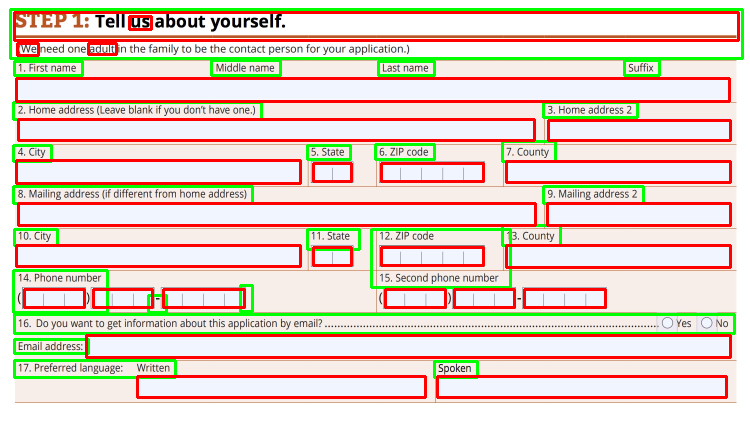

In [0]:


contours, hierarchy = cv2.findContours(
    thresh1, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)


res2=rgb.copy()
rects = []

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w*h>50 and w>5 and h>5 and w*h<thresh1.shape[0]*thresh1.shape[1]*0.5:
      
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.005 * peri,False)
      # check if the approximated contour has four points
      # if so, it can be labelled as a rectangle
      if len(approx) <25:
        rects.append((x,y,w,h))
        cv2.rectangle(res2,(x,y),(x+w,y+h), (0,0,255), 2)
        #rects.append(approx)


#cv2.drawContours(res2, rects, -1, (0, 0, 255), 2)


cv2_imshow(res2)